## **Regresión Logística y Validación Cruzada**

**1.** Se importa la base de datos `'train.csv'` la cual contiene mediciones de **82 variables en 21,263 materiales** superconductores diferentes. Para esto se utiliza la librería de `pandas`.

Para los propósitos de este proyecto, se seleccionaron solamente **5 de las 81 variables** de interés además de la variable de salida `critical_temp`.

Debido a que esta es una **variable cuantificada** y se va a trabajar con un modelo de regresión logística, **se convierte a variable binaria**. Para esto, se obtiene el **promedio de todas las temperaturas** y se genera una nueva variable llamada `high_temp`, en donde temperaturas más altas al promedio obtendrán el valor de **1** y más bajas el valor de **0**. Esta nueva variable es ahora la variable de salida, y se **elimina la variable de salida original** del dataframe.

Se imprime el promedio apartir del cual se define una temperatura como alta o baja y se imprime un resumen del dataframe.

In [121]:
import pandas as pd
df = pd.read_csv('train.csv')
temp_prom = df['critical_temp'].mean()
print("Temperatura Critica Promedio:", temp_prom)
df['high_temp'] = (df['critical_temp'] >= temp_prom).astype(int)
df = df.drop(columns = 'critical_temp')
print(df.head(3))

Temperatura Critica Promedio: 34.42121913535249
   number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
0                   4         88.944468             57.862692   
1                   5         92.729214             58.518416   
2                   4         88.944468             57.885242   

   gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
0          66.361592              36.116612             1.181795   
1          73.132787              36.396602             1.449309   
2          66.361592              36.122509             1.181795   

   wtd_entropy_atomic_mass  range_atomic_mass  wtd_range_atomic_mass  \
0                 1.062396          122.90607              31.794921   
1                 1.057755          122.90607              36.161939   
2                 0.975980          122.90607              35.741099   

   std_atomic_mass  ...  wtd_mean_Valence  gmean_Valence  wtd_gmean_Valence  \
0        51.968828  ...          2.257143       2.

**2.** Apartir de aquí, se reducen las variables a las **5** elegidas las cuales debido a su correlación con la variable de salida fueron:
- `'wtd_std_ThermalConductivity'`,
- `'wtd_mean_Valence'`,
- `'range_atomic_radius'`,
- `'wtd_entropy_atomic_mass'`,
- `'number_of_elements'`

Usando `train_test_split` de `sklearn` se separa el dataframe en datos de entrenamiento y de prueba con una relación **80/20**. Se calculan las **proporciones originales entre 0s y 1s**, y las proporciones en ambos datasets generados para **verificar que mantengan una proporción similar**.

In [122]:
from sklearn.model_selection import train_test_split
y = df['high_temp']
x = df.drop(columns = ['high_temp'])
x = df[['wtd_std_ThermalConductivity', 'wtd_mean_Valence', 'range_atomic_radius', 'wtd_entropy_atomic_mass', 'number_of_elements']]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=23)
prop_og = df['high_temp'].value_counts(normalize=True)
prop_train = y_train.value_counts(normalize=True)
prop_test = y_test.value_counts(normalize=True)
print("Proporcion de clase 1 en dataset original:",prop_og)
print("Proporcion de clase 1 en dataset de entrenamiento:",prop_train)
print("Proporcion de clase 1 en dataset de prueba:",prop_test)


Proporcion de clase 1 en dataset original: high_temp
0    0.623054
1    0.376946
Name: proportion, dtype: float64
Proporcion de clase 1 en dataset de entrenamiento: high_temp
0    0.621752
1    0.378248
Name: proportion, dtype: float64
Proporcion de clase 1 en dataset de prueba: high_temp
0    0.628262
1    0.371738
Name: proportion, dtype: float64


**3.** Usando el **dataset de entrenamiento**, se genera un **modelo de regresión logística** utilizando la función `LogisticRegression` de `sklearn` y utilizando la función `cross_val_score` y la tecnica de **K-fold** cross validation, se calcula la **exactitud promedio** con un valor de `k = 5`.

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

model = LogisticRegression()
model.fit(x_train, y_train)

print("Coeficientes:", model.coef_)
print("Intercepto:", model.intercept_)
scores = cross_val_score(model, x_train, y_train, cv = 5, scoring = 'accuracy')
print(f"Exactitud en cada fold: {scores}")
print(f"Exactitud promedio: {scores.mean():.4f}")

Coeficientes: [[ 0.01560908 -1.00419155  0.00533353  2.8805656  -0.13488148]]
Intercepto: [-3.32924117]
Exactitud en cada fold: [0.88536155 0.89006467 0.8856555  0.88418577 0.88918283]
Exactitud promedio: 0.8869


**4.** Utilizando el **modelo de regresión logística** se genera un **vector de probabilidades** para los datos de prueba. Además, se genera una **matriz de confusión** y se reportan **exactitud, sensibilidad y especificidad**. Para probar diferentes umbrales, se hacen los calculos para umbrales de **0.3, 0.5 y 0.7**.

Para esto, se utiliza la función `predict_proba` para generar el **vector de probabilidades**. Después, se define una función `ev_mod`, para **evaluar el modelo**, la cual toma un **umbral** y lo utiliza para realizar **predicciones con respecto a las probabilidades**. Utilizando la función `confusion_matrix` se genera la **matriz de confusión** y con la función `ravel` se extraen los valores de True Negative (**TN**), False Positive (**FP**), False Negative(**FN**), True Positive (**TP**) para posteriormente hacer el cálculo de la **especificidad**. Para calcular **exactitud** se importa la función `accuracy_score` y para **sensibilidad** `recall_score`.

Una vez definida la función, se aplica a los 3 valores de umbrales **0.3, 0.5 y 0.7** y se reportan las matrices de confusión y las características de las predicciones con cada umbral. Para una representación visual, también se genera una gráfica de barras con los resultados.

- Umbral: 0.3
Matriz de Confusión:
[[2078  594]
 [  93 1488]]
Exactitud: 0.8385
Sensibilidad (Recall): 0.9412
Especificidad: 0.7777
----------------------------------------
- Umbral: 0.5
Matriz de Confusión:
[[2349  323]
 [ 138 1443]]
Exactitud: 0.8916
Sensibilidad (Recall): 0.9127
Especificidad: 0.8791
----------------------------------------
- Umbral: 0.7
Matriz de Confusión:
[[2456  216]
 [ 385 1196]]
Exactitud: 0.8587
Sensibilidad (Recall): 0.7565
Especificidad: 0.9192
----------------------------------------
     Exactitud  Sensibilidad  Especificidad
0.3   0.838467      0.941176       0.777695
0.5   0.891606      0.912713       0.879117
0.7   0.858688      0.756483       0.919162


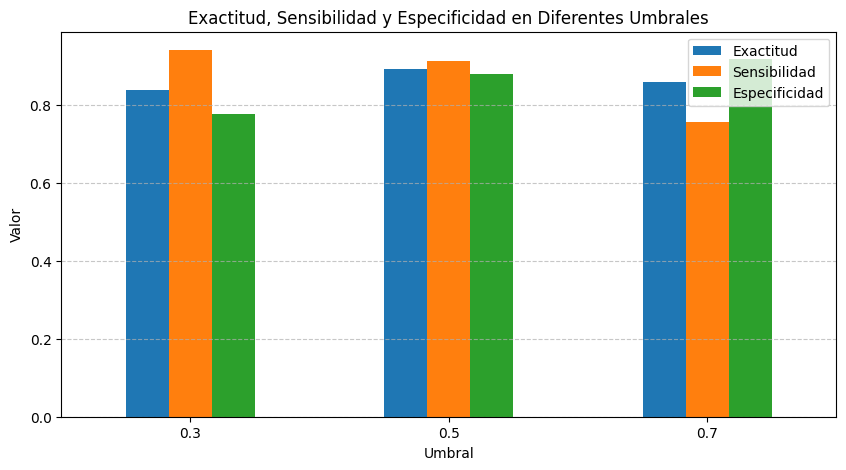

In [124]:
y_prob = model.predict_proba(x_test)[:,1]

def ev_mod(umbral):
  y_hat = (y_prob >= umbral).astype(int)

  cm = confusion_matrix(y_test,y_hat)
  TN, FP, FN, TP = cm.ravel()

  exactitud = accuracy_score(y_test, y_hat)
  sensibilidad = recall_score(y_test, y_hat)
  especificidad = TN / (TN + FP)
  print(f"- Umbral: {umbral}")
  print("Matriz de Confusión:")
  print(cm)
  print(f"Exactitud: {exactitud:.4f}")
  print(f"Sensibilidad (Recall): {sensibilidad:.4f}")
  print(f"Especificidad: {especificidad:.4f}")
  print("-" * 40)
  return exactitud, sensibilidad, especificidad
umbrales = [0.3, 0.5, 0.7]
resultados = []
for umbral in umbrales:
  resultados.append(ev_mod(umbral))
df_res = pd.DataFrame(resultados, columns = ['Exactitud','Sensibilidad','Especificidad'], index=umbrales)
print(df_res)

df_res.plot(kind='bar', figsize=(10,5))
plt.title("Exactitud, Sensibilidad y Especificidad en Diferentes Umbrales")
plt.xlabel("Umbral")
plt.ylabel("Valor")
plt.legend(loc="best")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.show()

**5.** Una vez obtenidos los resultados, se grafica la **curva ROC** para las probabilidades calculadas y se reporta el valor de la Area Under the Curve (**AUC**). Para esto se utilizan las funciones `roc_curve`, y `auc`.
Se calculan el **False Positive Rate** y **True Positive Rate** y se grafica utilizando la librería `matplotlib`.

Área Bajo la Curva (AUC): 0.9297


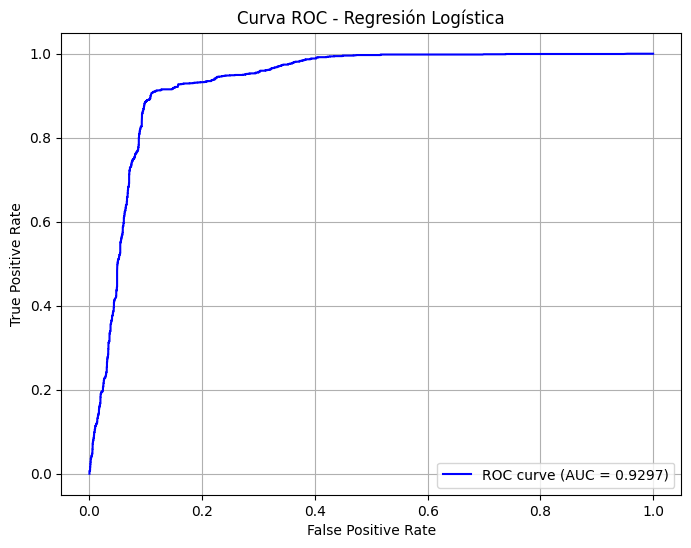

In [125]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr, tpr, _ = roc_curve(y_test, y_prob)

roc_auc = auc(fpr, tpr)
print(f"Área Bajo la Curva (AUC): {roc_auc:.4f}")

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Regresión Logística')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [126]:
coef=pd.DataFrame({"Variable": x_train.columns, "Coeficiente": model.coef_[0]})
print("Coeficientes del modelo:")
print(coef)

Coeficientes del modelo:
                      Variable  Coeficiente
0  wtd_std_ThermalConductivity     0.015609
1             wtd_mean_Valence    -1.004192
2          range_atomic_radius     0.005334
3      wtd_entropy_atomic_mass     2.880566
4           number_of_elements    -0.134881


## **Interpretación:**

Al ser un modelo de **regresión logística**, los coeficientes representan una **variación en el logaritmo natural de los odds** de que la temperatura sea alta. Variables como `wtd_std_ThermalConductivity` y `wtd_entropy_atomic_mass` que tienen un **coeficiente positivo**, es decir que **aumentan el logaritmo natural de los odds** de que el material tenga temperatura crítica alta, mientras que el `range_atomic_radius`, al tener un **coeficiente bajo**, tiene **poco efecto en los odds** de que el material tenga alta temperatura crítica. Por otro lado, `wtd_mean_Valence` y `number_of_elements` tienen **coeficientes negativos** y por lo tanto son variables que mientras más altas, **disminuyen el logaritmo natural de los odds** de que la temperatura crítica sea alta.
